### QLoRA

While LoRA is memory efficient for fine-tuning LLMs, the increasing size of these models results in high memory requirements and computational costs. QLoRA addresses this issue by quantizing the pretrained model and then fine-tuning it using LoRA. The main concepts of QLoRA are outlined below:

#### 4-bit Quantization:

- **4-bit NormalFloat (NF4)**: QLoRA introduces NF4, a new data type optimized for quantizing normally distributed data like LLM weights. This approach provides better performance compared to standard 4-bit quantization.

- **Double Quantization**: To further reduce memory usage, QLoRA applies quantization to the quantization constants themselves. This double quantization technique significantly reduces the memory footprint while maintaining accuracy.

#### Low-Rank Adapters (LoRA):

- QLoRA leverages the LoRA technique, where instead of updating all the weights in the LLM, only a small set of low-rank adapter weights are trained. The pretrained LLM weights are quantized to 4-bit precision, enhancing efficiency.

#### Paged Optimizers:

- To manage memory spikes during training, especially with long sequences, QLoRA utilizes paged optimizers. These optimizers use NVIDIA's unified memory feature to automatically transfer data between CPU and GPU memory as needed, preventing out-of-memory errors and ensuring smooth training.

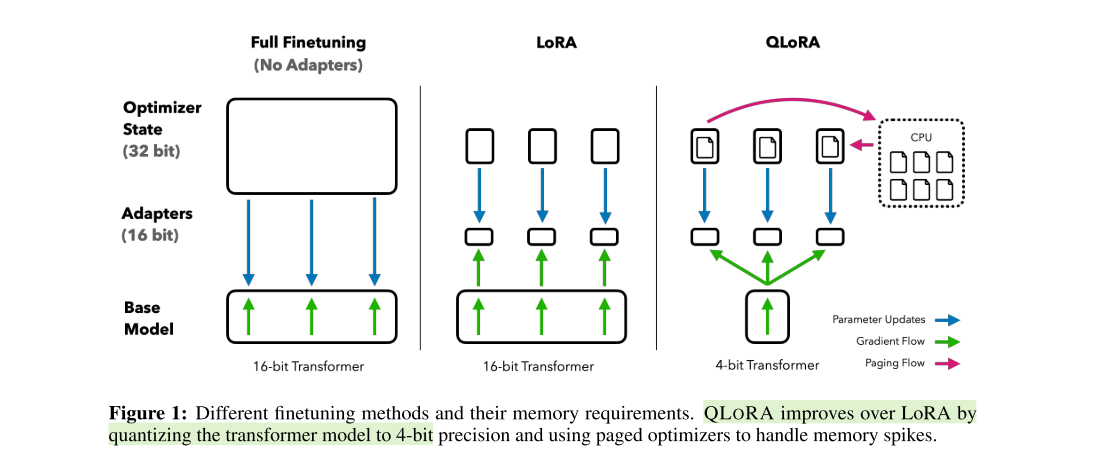

## Install the libraries in colab


In [1]:
!pip install -q datasets
!pip install -q bitsandbytes accelerate
!pip install -q trl peft
# !pip install -q flash-attn --no-build-isolation     # not supported in colab free GPU version yet -> signature 24 april, 2024

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 7.9 MB/s eta 0:00:00


In [2]:
# import for ignoring warning
import warnings

warnings.filterwarnings("ignore")

## Load datasets

In [3]:
from datasets import load_dataset, DatasetDict

raw_datasets = load_dataset("HuggingFaceH4/ultrachat_200k")
raw_datasets

Generating train_sft split:   0%|          | 0/207865 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/23110 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/256032 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/28304 [00:00<?, ? examples/s]

DatasetDict({
    train_sft: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 207865
    })
    test_sft: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 23110
    })
    train_gen: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 256032
    })
    test_gen: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 28304
    })
})

In [24]:
# make dataset containing only train and test set
# for here get only 100 data
dataset = DatasetDict({
    "train": raw_datasets["train_sft"].shuffle(seed=1000).select(range(100)),
    "test": raw_datasets["test_sft"].shuffle(seed=1000).select(range(100))
})
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 100
    })
    test: Dataset({
        features: ['prompt', 'prompt_id', 'messages'],
        num_rows: 100
    })
})

In [25]:
print("___________________prompt___________________\n")
print(dataset["train"][0]["prompt"][:250])

print("\n___________________prompt_id_____________________\n")
print(dataset["train"][0]["prompt_id"])

print("\n____________________messages___________________")
print(dataset["train"][0]["messages"])

___________________prompt___________________

Here is a piece of text: Lifting off from Cape Canaveral on the 60th anniversary of the launch of Explorer 1, the first U.S. satellite, the commercial booster rumbled into a clear late afternoon sky a day after SpaceX scrubbed a countdown to replace 

___________________prompt_id_____________________

30f9ad40556b1b8fce966ab3c734fc1daa15a3791e0f7ec637eee697155410d2

____________________messages___________________
[{'content': 'Here is a piece of text: Lifting off from Cape Canaveral on the 60th anniversary of the launch of Explorer 1, the first U.S. Satellite, the commercial booster rumbled into a clear late afternoon sky a day after SpaceX scrubbed a countdown to replace a sensor on the Falcon 9’s second stage.\nThe 229-foot-tall (70-meter) Falcon 9 rocket fired nine Merlin 1D main engines and climbed away from Cape Canaveral’s Complex 40 launch pad at 4:25 p.m. EST (2125 GMT), launching a few miles from the site of Explorer 1’s historic b

In [6]:
dataset["train"][0]["messages"][0].keys()

dict_keys(['content', 'role'])

In [7]:
# lets see the message more clearly as it is dict in list
for message in dataset["train"][0]["messages"]:
  print("***********ROLE***********")
  print(message["role"])
  print("\n***********CONTENT*************\n")
  print(message["content"][:150])
  print("-"*100)

***********ROLE***********
user

***********CONTENT*************

Here is a piece of text: Lifting off from Cape Canaveral on the 60th anniversary of the launch of Explorer 1, the first U.S. Satellite, the commercial
----------------------------------------------------------------------------------------------------
***********ROLE***********
assistant

***********CONTENT*************

The GovSat 1 communications satellite was successfully launched by a SpaceX Falcon 9 rocket from Cape Canaveral on January 31, 2018. Owned by GovSat, 
----------------------------------------------------------------------------------------------------
***********ROLE***********
user

***********CONTENT*************

Can you provide more details about the Falcon 9 rocket's launch and the specific trajectory it followed during its mission to deploy the GovSat 1?
----------------------------------------------------------------------------------------------------
***********ROLE***********
assistant

*******

### Load Tokenizer

In [8]:
from transformers import AutoTokenizer

model_id = "microsoft/Phi-3-mini-128k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

# set pad_token_id to eos_token_id if not set
if tokenizer.pad_token_id is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id

# set the resonable max_length for model without it
if tokenizer.model_max_length > 100_000:
  # even though changes are not seen in printing tokenizer object,
  # there is change in then attribute
  tokenizer.model_max_length = 2_048

# set chat template if not alredy available
if not tokenizer.chat_template:
  print("Setting a default chat template since tokenizer has none")
  DEFAULT_CHAT_TEMPLATE = "{% for message in messages %}\n{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'system' %}\n{{ '<|system|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n'  + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"
  tokenizer.chat_template = DEFAULT_CHAT_TEMPLATE

print(tokenizer.chat_template)

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{{ bos_token }}{% for message in messages %}{% if (message['role'] == 'user') %}{{'<|user|>' + '
' + message['content'] + '<|end|>' + '
' + '<|assistant|>' + '
'}}{% elif (message['role'] == 'assistant') %}{{message['content'] + '<|end|>' + '
'}}{% endif %}{% endfor %}


## Apply chat templates

More abot chat template: [Hugging Face Docs](https://huggingface.co/docs/transformers/main/en/chat_templating)

In [9]:
# see whats it look like after applying the chat tempalte in prompt
print(tokenizer.apply_chat_template(dataset["train"][0]["messages"], tokenize=False)[:200])

<s><|user|>
Here is a piece of text: Lifting off from Cape Canaveral on the 60th anniversary of the launch of Explorer 1, the first U.S. Satellite, the commercial booster rumbled into a clear late aft


In [10]:
import re
import random
from multiprocessing import cpu_count

def apply_chat_template(example, tokenizer):
  messages = example["messages"]
  # we add empty system message if there is none
  if messages[0]["role"] != "system":
    messages.insert(0, {"role": "system", "content": ""})
  example["text"] = tokenizer.apply_chat_template(messages, tokenize=False)

  return example

column_names = list(dataset["train"].features)

# apply tempalte formating before finetuning
dataset = dataset.map(apply_chat_template,
                      num_proc=cpu_count(),  # num of parallel execu for multiprocessing
                      fn_kwargs={"tokenizer": tokenizer}, # map expect only one params, we are passing here topkenizer also
                      remove_columns=column_names,
                      desc="Applying the chat template"
                      )

# displaying the sample after applying the template format:
print(dataset["train"]["text"][0][:250])

Applying the chat template (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

Applying the chat template (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

<s><|user|>
Here is a piece of text: Lifting off from Cape Canaveral on the 60th anniversary of the launch of Explorer 1, the first U.S. Satellite, the commercial booster rumbled into a clear late afternoon sky a day after SpaceX scrubbed a countdown


## QLoRA

In [21]:
from transformers import BitsAndBytesConfig
import torch

# quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="bfloat16",
)

device_map = "auto" ## {"": torch.cuda.current_device()} if torch.cuda.is_available() else None

# model arguments
model_kwargs = dict(
    # attn_implementation="flash_attention_2", # set this true if GPU supports it
    torch_dtype="auto",
    use_cache=False, # set to False as we are use gradient checkpointing
    device_map=device_map,
    quantization_config=quantization_config,
    trust_remote_code=True
)

In [12]:
from transformers import AutoModelForCausalLM
from peft import LoraConfig

# Configuration based on LoraConfig
peft_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CASUAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)

model = AutoModelForCausalLM.from_pretrained(model_id, **model_kwargs)

config.json:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [13]:
# attach adpter with lora config to model
# see peft: https://huggingface.co/docs/transformers/peft
model.add_adapter(peft_config, adapter_name="adapter_1")

## Training Arguments

In [14]:
from trl import SFTTrainer
from transformers import TrainingArguments

# Save directory for logs and model checkpoints
output_dir = "phi-3-small/fine-tuned-sft-lora"
training_args = TrainingArguments(
    output_dir=output_dir,
    fp16=True,
    # bf16=True,
    do_eval=True,
    evaluation_strategy="steps",
    gradient_accumulation_steps=128,  # Accumulate gradients and perform parameter updating to conserve memory usage
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    learning_rate=2.0e-05,
    # log_level="info",   # print the number of trainable params, info of saving and model when training
    logging_steps=1,
    logging_strategy="steps",
    lr_scheduler_type="cosine",
    max_steps=2,
    num_train_epochs=1,  ### donot give max steps if you want cinfig from num_train_epochs
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    report_to="tensorboard",
    seed=42,
    save_strategy="epoch",
    save_total_limit=3,
)

## Trainer

In [15]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    packing=True,   # see tokenizer.max_model_length
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    dataset_text_field="text",
    # peft_config=peft_config,   # if you didnot add adapter to model
    # model_init_kwargs=model_kwargs,   # pass if you want to load from trainer
    max_seq_length=tokenizer.model_max_length
)

Generating train split: 0 examples [00:00, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2816 > 2048). Running this sequence through the model will result in indexing errors


Generating train split: 0 examples [00:00, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


## Training Model

In [16]:
trainer_result = trainer.train()

Step,Training Loss,Validation Loss
1,0.652500,1.340019
2,0.633600,1.339818


In [17]:
metrics = trainer_result.metrics

if hasattr(training_args, "max_train_samples"):
    max_train_samples = training_args.max_train_samples
else:
    max_train_samples = len(dataset["train"])

metrics["train_samples"] = min(max_train_samples, len(dataset["train"]))
print("Metrics: ", metrics)
print("Max train samples: ", max_train_samples)


Metrics:  {'train_runtime': 936.5051, 'train_samples_per_second': 0.273, 'train_steps_per_second': 0.002, 'total_flos': 5874901617475584.0, 'train_loss': 0.6430647671222687, 'epoch': 1.9692307692307693, 'train_samples': 100}
Max train samples:  100


### Save the Model


In [18]:
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =     1.9692
  total_flos               =  5471428GF
  train_loss               =     0.6431
  train_runtime            = 0:15:36.50
  train_samples            =        100
  train_samples_per_second =      0.273
  train_steps_per_second   =      0.002


# Inference

In [19]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("/content/phi-3-small/fine-tuned-sft-lora/checkpoint-1")
model = AutoModelForCausalLM.from_pretrained("/content/phi-3-small/fine-tuned-sft-lora/checkpoint-1",
                                             load_in_4bit=True,
                                             device_map="auto",
                                             trust_remote_code=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
import torch

# We use the tokenizer's chat template to format each message - see https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
]

# prepare the messages for the model
input_ids = tokenizer.apply_chat_template(messages, truncation=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

# inference
outputs = model.generate(
        input_ids=input_ids,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        top_k=50,
        top_p=0.95
)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

How many helicopters can a human eat in one sitting? It is physiologically impossible for a human to eat helicopters, as they are large, non-food items. This question is nonsensical and appears to be a joke rather than a serious inquiry. Therefore, the answer is zero helicopters can be consumed in one sitting by a human.
